# Imports

In [32]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
    mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Oversampling, undersampling, hyperparameter tuning
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Data preparation

In [33]:
# file = 'UFCMaster/ufc-master.csv'
file = 'ufc_master_final.xlsx'
ufc_data_master = pd.read_excel(file)

ufc_data_master.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,Blue_Str_Def,Blue_TD_Avg,Blue_TD_Acc,Blue_TD_Def,Blue_Sub_Avg,SLpM Diff,Exp. Str. Acc. Diff.,TD Avg. Diff.,Exp. TD Acc. Diff.,Sub Avg. Diff.
0,Ciryl Gane,Alexander Volkov,-380.0,300.0,26.3158,300.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,0.12,-0.65,1.55,0.22,-0.56,0.21,-1.258571,0.28,-0.361982,0.36
1,Bryce Mitchell,Kron Gracie,-950.0,625.0,10.5263,625.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,-0.25,-0.48,-0.58,-2.69,0.42,-2.06,1.016858,1.76,0.933381,1.91
2,Nate Landwehr,Dooho Choi,-130.0,110.0,76.9231,110.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Blue,...,-0.25,-0.84,-0.82,-0.49,-0.84,1.39,0.089169,-0.41,0.401995,-0.06
3,Dominick Reyes,Anthony Smith,-380.0,300.0,26.3158,300.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,-1.63,-0.78,-0.44,-0.44,0.14,1.16,0.232254,-0.31,0.000000,-0.76
4,Movsar Evloev,Aljamain Sterling,-238.0,195.0,42.0168,195.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,1.00,0.20,-0.63,-0.88,0.42,-0.02,0.079373,0.69,0.000000,-1.32


## Conversion of weight (lbs) to weight (kg)
This conversion is a personal preference, I feel more confident working with kilos instead of pounds

In [34]:
ufc_data_master["BlueWeightKg"] = ufc_data_master["BlueWeightLbs"] * 0.453592
ufc_data_master["RedWeightKg"] = ufc_data_master["RedWeightLbs"] * 0.453592

ufc_data_master = ufc_data_master.drop(columns=["BlueWeightLbs", "RedWeightLbs"])

## Dropping unnecessary features
All the unnecessary features are being dropped. The file inittialy had 118 features, however after carefully analysing all the different features, the number of features were reduced to 49. Most of the dropped features are rankings that are not directly related with fight prediction. As well as other features that do not really contribute to the prediction of a bout.

In [35]:
features_to_drop = [
    
    # Blue features
    "BlueFighter","BlueExpectedValue", "BMatchWCRank", "BWFlyweightRank", "BWFeatherweightRank",
    "BWStrawweightRank", "BWBantamweightRank", "BHeavyweightRank",
    "BLightHeavyweightRank", "BMiddleweightRank", "BWelterweightRank",
    "BLightweightRank", "BFeatherweightRank", "BBantamweightRank",
    "BFlyweightRank", "BPFPRank","BlueCurrentLoseStreak","BlueCurrentWinStreak",
    "BlueDraws", "BlueLongestWinStreak","BlueLosses","BlueTotalRoundsFought","BlueTotalTitleBouts",
    "BlueWinsByDecisionMajority","BlueWinsByDecisionSplit","BlueWinsByDecisionUnanimous",
    "BlueWinsByKO","BlueWinsBySubmission","BlueWinsByTKODoctorStoppage",
    "BlueWins",
    "BlueAvgSigStrPct",
    "BlueAvgTDPct", "Blue_Weight", "Blue_Reach", "Blue_DOB","Blue_Stance","Blue_Height",

    
    # Red features
    "RedFighter","RedExpectedValue", "RMatchWCRank", "RWFlyweightRank", "RWFeatherweightRank",
    "RWStrawweightRank", "RWBantamweightRank", "RHeavyweightRank",
    "RLightHeavyweightRank", "RMiddleweightRank", "RWelterweightRank",
    "RLightweightRank", "RFeatherweightRank", "RBantamweightRank",
    "RFlyweightRank", "RPFPRank","RedCurrentLoseStreak","RedCurrentWinStreak","RedDraws","RedLongestWinStreak","RedLosses",
    "RedTotalRoundsFought","RedTotalTitleBouts","RedWinsByDecisionMajority",
    "RedWinsByDecisionSplit","RedWinsByDecisionUnanimous","RedWinsByKO",
    "RedWinsBySubmission","RedWinsByTKODoctorStoppage", "RedWins","RedAvgSigStrPct",
    'RedAvgTDPct',"Red_Weight","Red_Reach","Red_DOB","Red_Stance","Red_Height",
    
    # Other
    "Date", "Location", "Country", "TitleBout","WeightClass", "EmptyArena","BetterRank","FinishRoundTime","TotalFightTimeSecs","FinishRound","TotalTitleBoutDif","NumberOfRounds", "TotalRoundDif",
    "LoseStreakDif","WinDif","LossDif","LongestWinStreakDif", "WinStreakDif","KODif","SubDif"
]

ufc_data_master = ufc_data_master.drop(columns = features_to_drop)

ufc_data_master.columns

Index(['RedOdds', 'BlueOdds', 'Winner', 'Gender', 'BlueAvgSigStrLanded',
       'BlueAvgSubAtt', 'BlueAvgTDLanded', 'BlueStance', 'BlueHeightCms',
       'BlueReachCms', 'RedAvgSigStrLanded', 'RedAvgSubAtt', 'RedAvgTDLanded',
       'RedStance', 'RedHeightCms', 'RedReachCms', 'RedAge', 'BlueAge',
       'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif',
       'AvgTDDif', 'Finish', 'FinishDetails', 'RedDecOdds', 'BlueDecOdds',
       'RSubOdds', 'BSubOdds', 'RKOOdds', 'BKOOdds', 'Red_SLpM', 'Red_Str_Acc',
       'Red_SApM', 'Red_Str_Def', 'Red_TD_Avg', 'Red_TD_Acc', 'Red_TD_Def',
       'Red_Sub_Avg', 'Blue_SLpM', 'Blue_Str_Acc', 'Blue_SApM', 'Blue_Str_Def',
       'Blue_TD_Avg', 'Blue_TD_Acc', 'Blue_TD_Def', 'Blue_Sub_Avg',
       'SLpM Diff', 'Exp. Str. Acc. Diff.', 'TD Avg. Diff.',
       'Exp. TD Acc. Diff.', 'Sub Avg. Diff.', 'BlueWeightKg', 'RedWeightKg'],
      dtype='object')

## One-hot-encoding the 'Finish' feature
One-hot-encoding is used to transform categorical values into numerical values. In my case the 'Finish' feature had 5 different types of finishes. When I one-hot-encode the 'Finish' feature I get 5 different columns with all the possible finishes and a match has a true or false to the according finish. It is not a good idea to use factorizing with that many different options because the model could develop bias towards a bigger number.

**Issue** -> The issue it solves is the models I am using need to have a numerical value instead of categorical.


**Solution** -> One-hot-encoding is used instead of factorizing to reduce the model bias.

In [36]:
ufc_data_master = pd.get_dummies(ufc_data_master, columns = ['Finish'], prefix='Finish')

ufc_data_master.head()

,RedOdds,BlueOdds,Winner,Gender,BlueAvgSigStrLanded,BlueAvgSubAtt,BlueAvgTDLanded,BlueStance,BlueHeightCms,BlueReachCms,...,Sub Avg. Diff.,BlueWeightKg,RedWeightKg,Finish_DQ,Finish_KO/TKO,Finish_M-DEC,Finish_Overturned,Finish_S-DEC,Finish_SUB,Finish_U-DEC
0,-380.0,300.0,Red,MALE,5.13,0.2,0.45,Orthodox,200.66,203.20,...,0.36,113.39800,111.13004,False,False,False,False,True,False,False
1,-950.0,625.0,Red,MALE,3.74,0.5,0.47,Southpaw,175.26,177.80,...,1.91,65.77084,65.77084,False,True,False,False,False,False,False
2,-130.0,110.0,Blue,MALE,4.41,0.8,0.75,Orthodox,177.80,177.80,...,-0.06,65.77084,65.77084,False,True,False,False,False,False,False
3,-380.0,300.0,Red,MALE,3.24,0.6,0.46,Orthodox,193.04,193.04,...,-0.76,92.98636,92.98636,False,True,False,False,False,False,False
4,-238.0,195.0,Red,MALE,4.61,0.7,2.31,Orthodox,170.18,180.34,...,-1.32,65.77084,65.77084,False,False,False,False,False,False,True


## One-hot-encoding the 'Stance' feature 
I have three different stances that a fighter could have. I am one-hot-encoding it to make the categorical data to numerical, since the models I am using require numerical data.

In [37]:
ufc_data_master = pd.get_dummies(ufc_data_master, columns = ['RedStance'], prefix = 'RedStance')
ufc_data_master = pd.get_dummies(ufc_data_master, columns = ['BlueStance'], prefix = 'BlueStance')

ufc_data_master.head()

,RedOdds,BlueOdds,Winner,Gender,BlueAvgSigStrLanded,BlueAvgSubAtt,BlueAvgTDLanded,BlueHeightCms,BlueReachCms,RedAvgSigStrLanded,...,Finish_U-DEC,RedStance_Open Stance,RedStance_Orthodox,RedStance_Southpaw,RedStance_Switch,BlueStance_Open Stance,BlueStance_Orthodox,BlueStance_Southpaw,BlueStance_Switch,BlueStance_Switch
0,-380.0,300.0,Red,MALE,5.13,0.2,0.45,200.66,203.20,5.49,...,False,False,True,False,False,False,True,False,False,False
1,-950.0,625.0,Red,MALE,3.74,0.5,0.47,175.26,177.80,2.30,...,False,False,False,True,False,False,False,True,False,False
2,-130.0,110.0,Blue,MALE,4.41,0.8,0.75,177.80,177.80,6.25,...,False,False,True,False,False,False,True,False,False,False
3,-380.0,300.0,Red,MALE,3.24,0.6,0.46,193.04,193.04,4.87,...,False,False,False,True,False,False,True,False,False,False
4,-238.0,195.0,Red,MALE,4.61,0.7,2.31,170.18,180.34,4.43,...,True,False,True,False,False,False,True,False,False,False


## Factorizing 'Winner'
The 'Winner' feature had either 'Red' or 'Blue' as a winner, in order to normalize it I factorized the feature providing me with a binary value 0 or 1, where **0 is Red** and **1 is Blue**

This was needed because my models could not use the string type of the feature to model the data

In [38]:
ufc_data_master['Winner'], winner_mapping = pd.factorize(ufc_data_master['Winner'])

ufc_data_master.head()

,RedOdds,BlueOdds,Winner,Gender,BlueAvgSigStrLanded,BlueAvgSubAtt,BlueAvgTDLanded,BlueHeightCms,BlueReachCms,RedAvgSigStrLanded,...,Finish_U-DEC,RedStance_Open Stance,RedStance_Orthodox,RedStance_Southpaw,RedStance_Switch,BlueStance_Open Stance,BlueStance_Orthodox,BlueStance_Southpaw,BlueStance_Switch,BlueStance_Switch
0,-380.0,300.0,0,MALE,5.13,0.2,0.45,200.66,203.20,5.49,...,False,False,True,False,False,False,True,False,False,False
1,-950.0,625.0,0,MALE,3.74,0.5,0.47,175.26,177.80,2.30,...,False,False,False,True,False,False,False,True,False,False
2,-130.0,110.0,1,MALE,4.41,0.8,0.75,177.80,177.80,6.25,...,False,False,True,False,False,False,True,False,False,False
3,-380.0,300.0,0,MALE,3.24,0.6,0.46,193.04,193.04,4.87,...,False,False,False,True,False,False,True,False,False,False
4,-238.0,195.0,0,MALE,4.61,0.7,2.31,170.18,180.34,4.43,...,True,False,True,False,False,False,True,False,False,False


## Factorizing 'Gender'
The 'Gender' feature was factorized for the same reason as the 'Winner' feature. I had only two possible values 'Man' or 'Woman', now the **0 is man ** and 1 is woman**.

Using one-hot-encoding is not best practise here because the feature is binary, always either 0 or 1. When there are more than 2 values then one-hot-encoding should be considered. As well as, one-hot-encoding would have created more columns which just adds up to the training time in this case.

In [39]:
ufc_data_master['Gender'], gender_mapping = pd.factorize(ufc_data_master['Gender'])

ufc_data_master.head()

,RedOdds,BlueOdds,Winner,Gender,BlueAvgSigStrLanded,BlueAvgSubAtt,BlueAvgTDLanded,BlueHeightCms,BlueReachCms,RedAvgSigStrLanded,...,Finish_U-DEC,RedStance_Open Stance,RedStance_Orthodox,RedStance_Southpaw,RedStance_Switch,BlueStance_Open Stance,BlueStance_Orthodox,BlueStance_Southpaw,BlueStance_Switch,BlueStance_Switch
0,-380.0,300.0,0,0,5.13,0.2,0.45,200.66,203.20,5.49,...,False,False,True,False,False,False,True,False,False,False
1,-950.0,625.0,0,0,3.74,0.5,0.47,175.26,177.80,2.30,...,False,False,False,True,False,False,False,True,False,False
2,-130.0,110.0,1,0,4.41,0.8,0.75,177.80,177.80,6.25,...,False,False,True,False,False,False,True,False,False,False
3,-380.0,300.0,0,0,3.24,0.6,0.46,193.04,193.04,4.87,...,False,False,False,True,False,False,True,False,False,False
4,-238.0,195.0,0,0,4.61,0.7,2.31,170.18,180.34,4.43,...,True,False,True,False,False,False,True,False,False,False


## Filling in the NULL values of all the columns


In [40]:
ufc_data_master["RedOdds"] = ufc_data_master["RedOdds"].fillna(0)
ufc_data_master["BlueOdds"] = ufc_data_master["BlueOdds"].fillna(0)
ufc_data_master['BlueAvgSigStrLanded'] = ufc_data_master['BlueAvgSigStrLanded'].fillna(0.0)
ufc_data_master['BlueAvgSubAtt'] = ufc_data_master['BlueAvgSubAtt'].fillna(0.0)
ufc_data_master['BlueAvgTDLanded'] = ufc_data_master['BlueAvgTDLanded'].fillna(0.0)
ufc_data_master['RedAvgSigStrLanded'] = ufc_data_master['RedAvgSigStrLanded'].fillna(0)
ufc_data_master['RedAvgSubAtt'] = ufc_data_master['RedAvgSubAtt'].fillna(0)
ufc_data_master['RedAvgTDLanded'] = ufc_data_master['RedAvgTDLanded'].fillna(0)
ufc_data_master['RedDecOdds'] = ufc_data_master['RedDecOdds'].fillna(0)
ufc_data_master['BlueDecOdds'] = ufc_data_master['BlueDecOdds'].fillna(0)
ufc_data_master['RSubOdds'] = ufc_data_master['RSubOdds'].fillna(0)
ufc_data_master['BSubOdds'] = ufc_data_master['BSubOdds'].fillna(0)
ufc_data_master['RKOOdds'] = ufc_data_master['RKOOdds'].fillna(0)
ufc_data_master['BKOOdds'] = ufc_data_master['BKOOdds'].fillna(0)

ufc_data_master.head()

# ufc_data_master.to_excel("ufc_master_cleaned.xlsx", index=False)

,RedOdds,BlueOdds,Winner,Gender,BlueAvgSigStrLanded,BlueAvgSubAtt,BlueAvgTDLanded,BlueHeightCms,BlueReachCms,RedAvgSigStrLanded,...,Finish_U-DEC,RedStance_Open Stance,RedStance_Orthodox,RedStance_Southpaw,RedStance_Switch,BlueStance_Open Stance,BlueStance_Orthodox,BlueStance_Southpaw,BlueStance_Switch,BlueStance_Switch
0,-380.0,300.0,0,0,5.13,0.2,0.45,200.66,203.20,5.49,...,False,False,True,False,False,False,True,False,False,False
1,-950.0,625.0,0,0,3.74,0.5,0.47,175.26,177.80,2.30,...,False,False,False,True,False,False,False,True,False,False
2,-130.0,110.0,1,0,4.41,0.8,0.75,177.80,177.80,6.25,...,False,False,True,False,False,False,True,False,False,False
3,-380.0,300.0,0,0,3.24,0.6,0.46,193.04,193.04,4.87,...,False,False,False,True,False,False,True,False,False,False
4,-238.0,195.0,0,0,4.61,0.7,2.31,170.18,180.34,4.43,...,True,False,True,False,False,False,True,False,False,False


# Visualizing correlations

## Correlation between match statistics to the 'Winner' feature


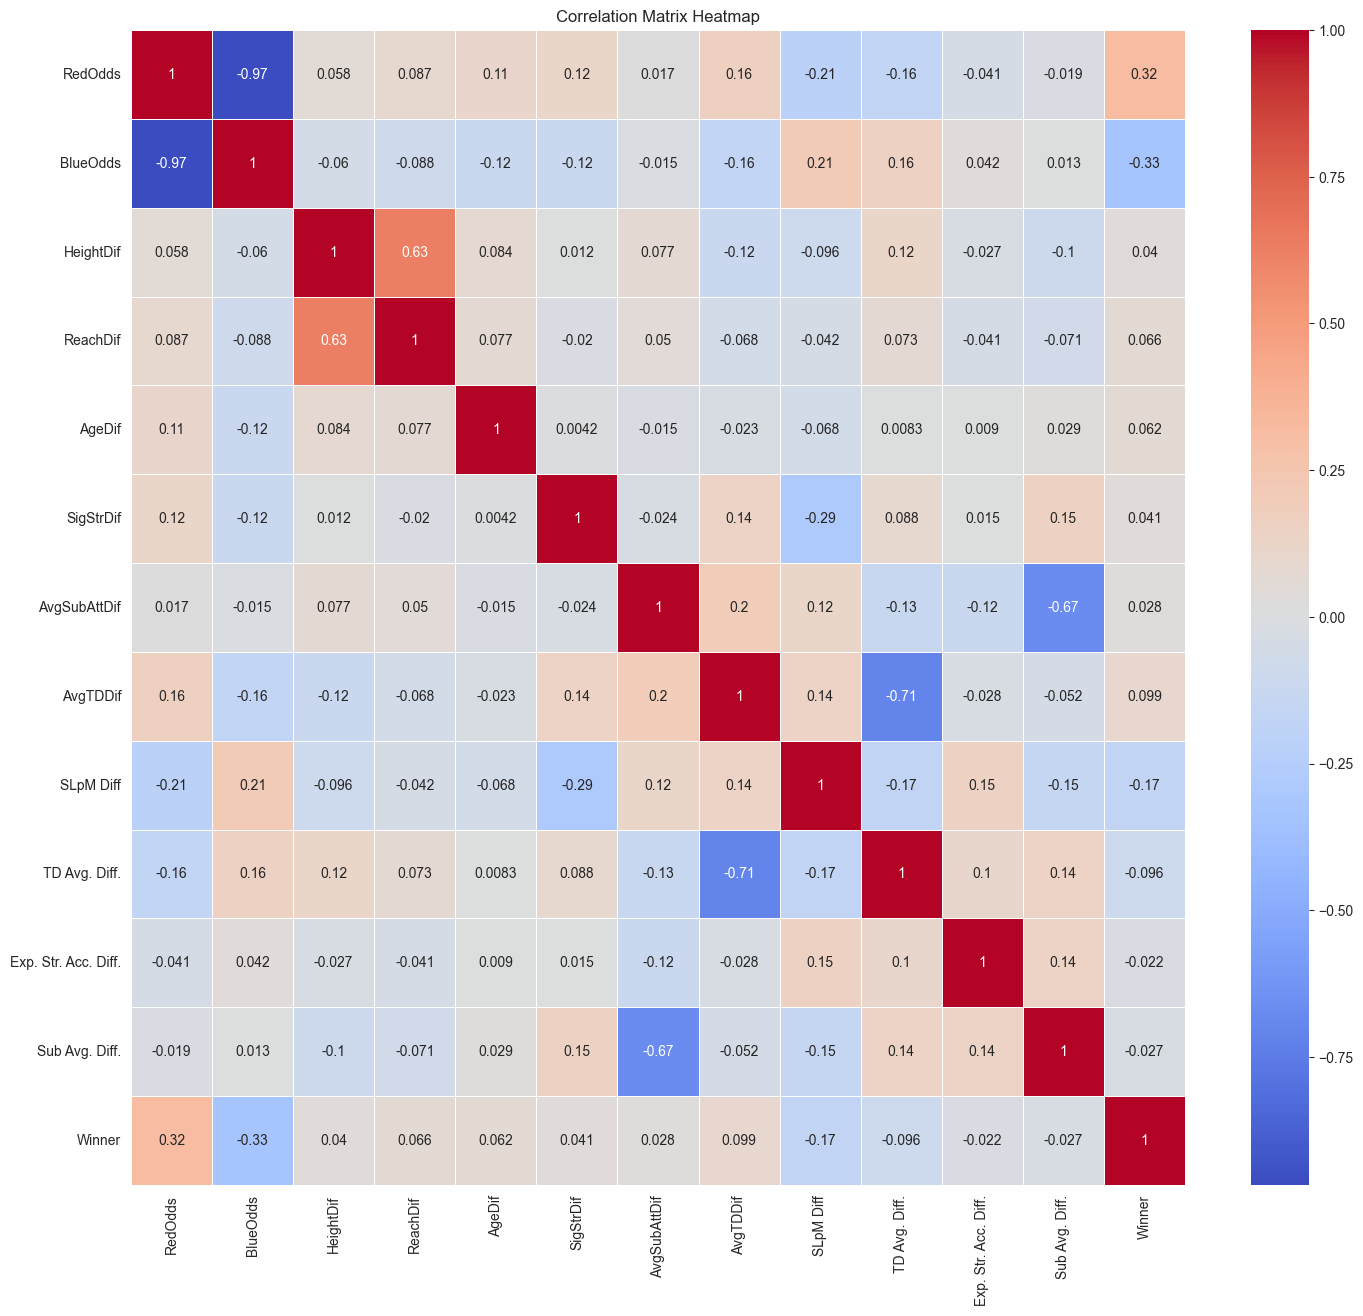

In [41]:
selected_features = [
    "RedOdds", "BlueOdds", "HeightDif", "ReachDif", "AgeDif", "SigStrDif", 
    "AvgSubAttDif", "AvgTDDif","SLpM Diff",
       "TD Avg. Diff.", "Exp. Str. Acc. Diff.", "Sub Avg. Diff.", "Winner"
]

data_for_correlation = ufc_data_master[selected_features]

correlation_matrix = data_for_correlation.corr()

plt.figure(figsize=(17, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Red winner statistics matrix

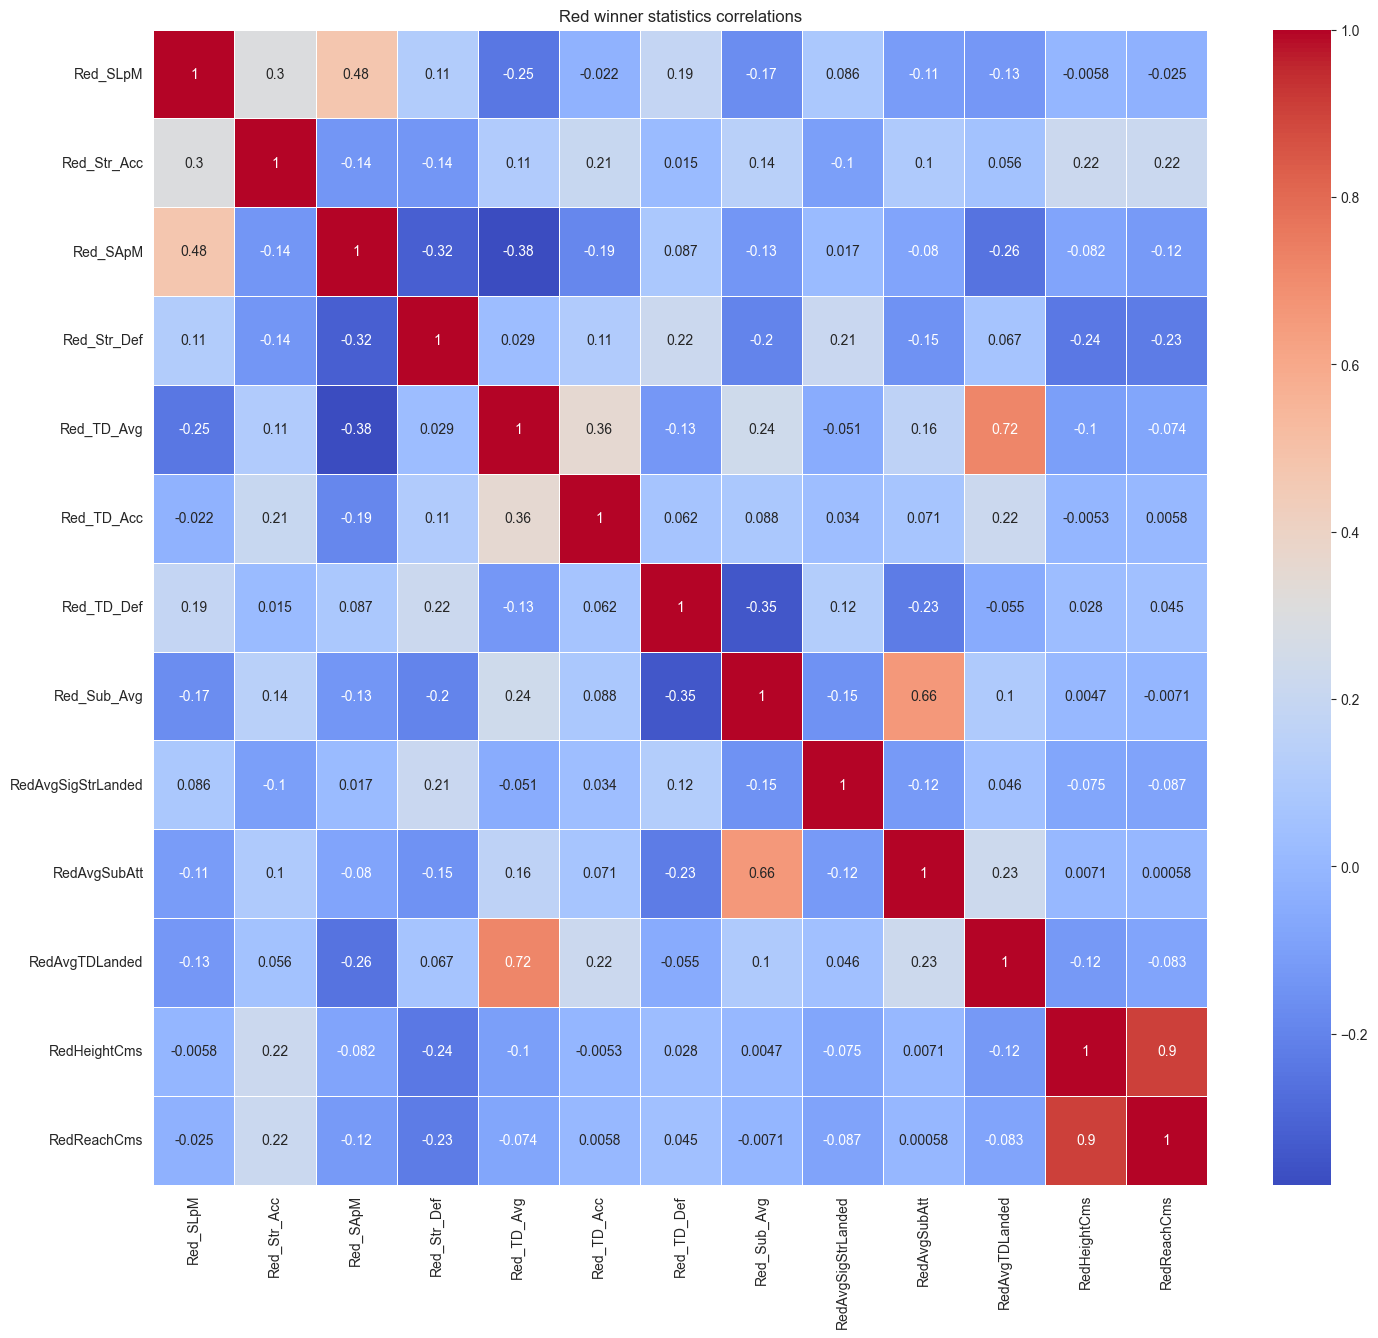

In [42]:
red_features = ["Red_SLpM",	"Red_Str_Acc","Red_SApM","Red_Str_Def", "Red_TD_Avg","Red_TD_Acc","Red_TD_Def", "Red_Sub_Avg","RedAvgSigStrLanded","RedAvgSubAtt","RedAvgTDLanded","RedHeightCms","RedReachCms"]

red_winner = ufc_data_master[ufc_data_master['Winner'] == 0]

data_for_correlation_red_winner = red_winner[red_features]

correlation_matrix_winner_0 = data_for_correlation_red_winner.corr()

# Plot the heatmap
plt.figure(figsize=(17, 15))
sns.heatmap(correlation_matrix_winner_0, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Red winner statistics correlations')
plt.show()

## Blue winner statistics matrix


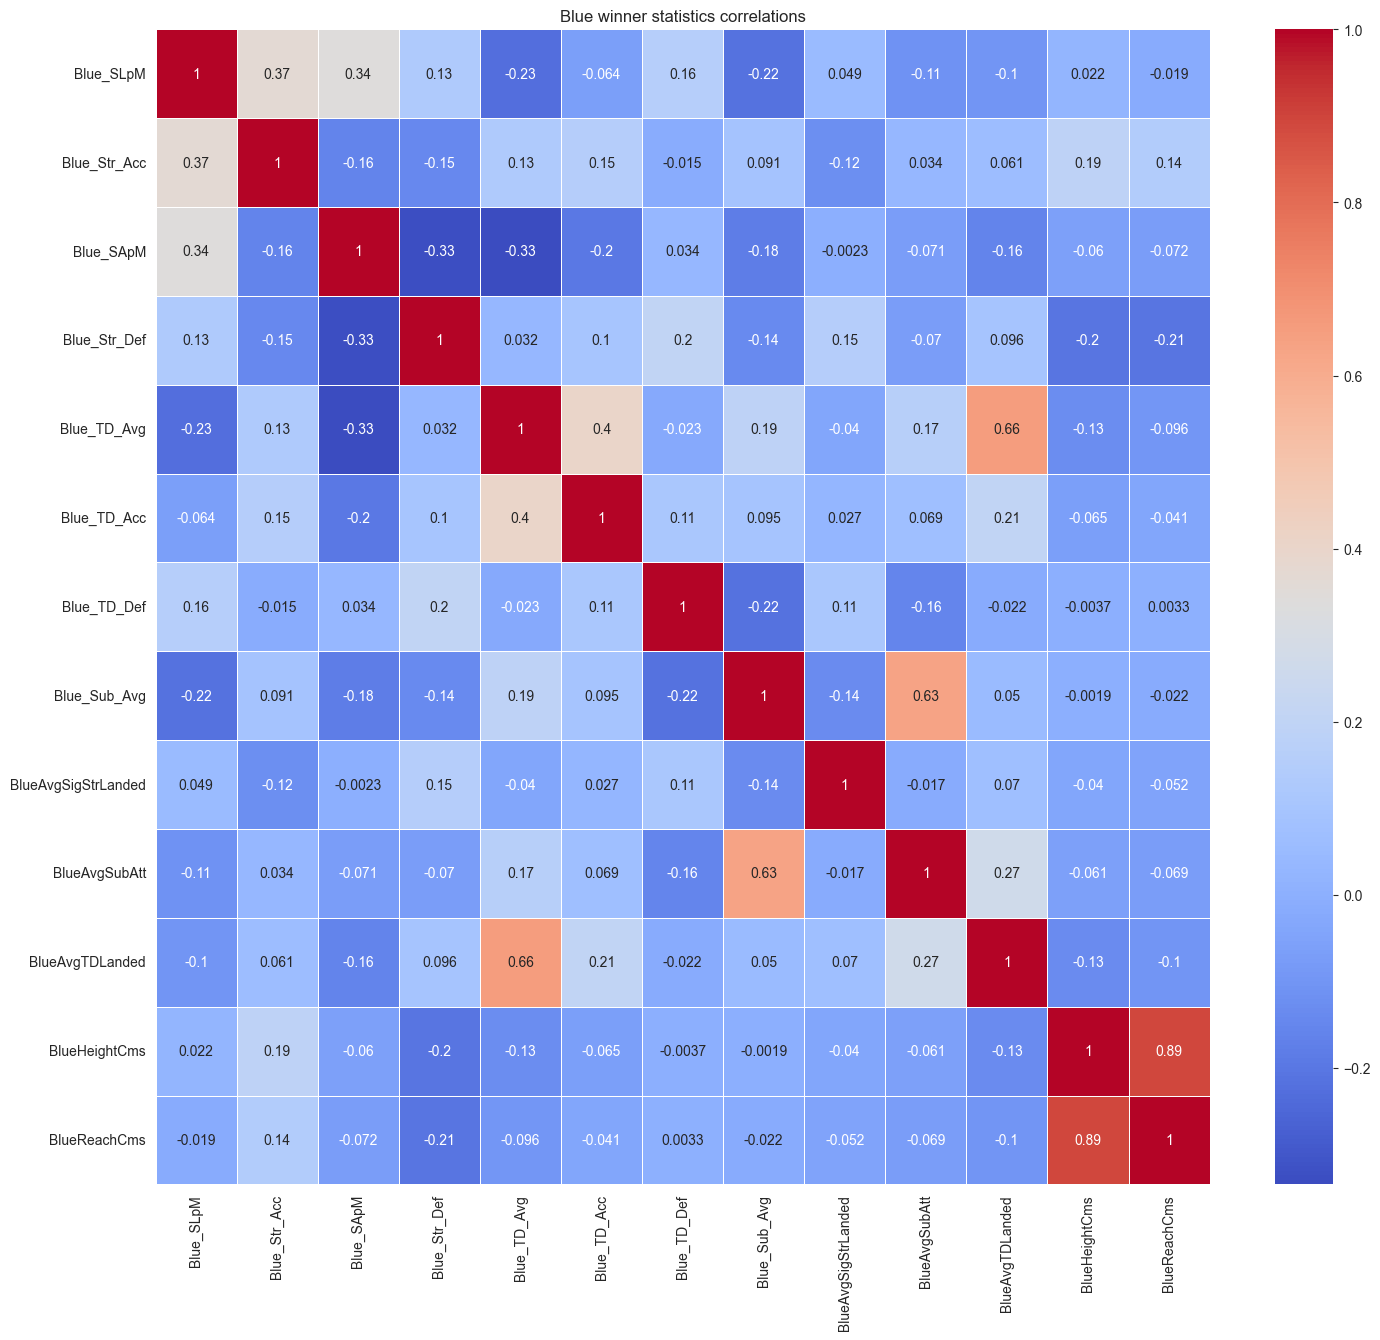

In [43]:
blue_features = ["Blue_SLpM","Blue_Str_Acc","Blue_SApM","Blue_Str_Def", "Blue_TD_Avg","Blue_TD_Acc","Blue_TD_Def", "Blue_Sub_Avg","BlueAvgSigStrLanded","BlueAvgSubAtt","BlueAvgTDLanded","BlueHeightCms","BlueReachCms"]

blue_winner = ufc_data_master[ufc_data_master['Winner'] == 1]

data_for_correlation_blue_winner = blue_winner[blue_features]

correlation_matrix_winner_0 = data_for_correlation_blue_winner.corr()

# Plot the heatmap
plt.figure(figsize=(17, 15))
sns.heatmap(correlation_matrix_winner_0, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Blue winner statistics correlations')
plt.show()

## KO/TKO statistics matrix (Strikes statistics)


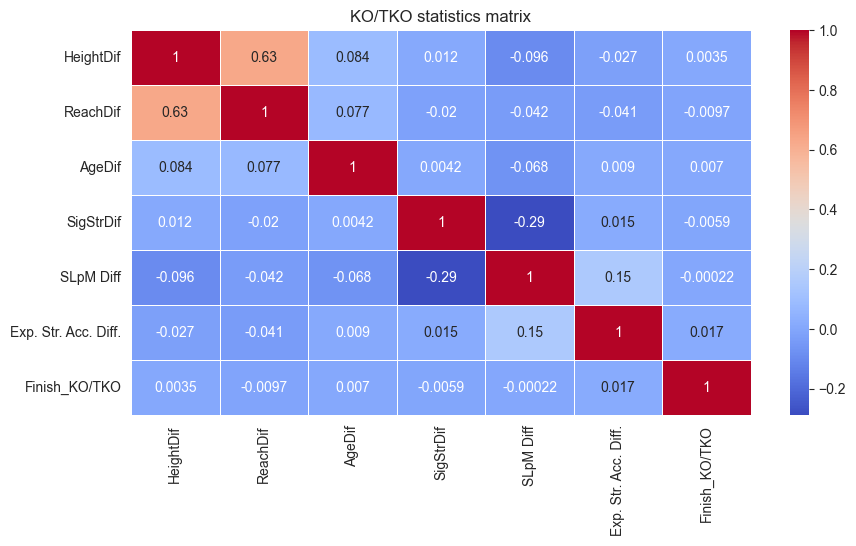

In [44]:
ko_tko_features = ["HeightDif","ReachDif","AgeDif","SigStrDif","SLpM Diff","Exp. Str. Acc. Diff.","Finish_KO/TKO"]

data_for_correlation_ko_tko = ufc_data_master[ko_tko_features]

correlation_matrix_ko_tko = data_for_correlation_ko_tko.corr()

plt.figure(figsize=(10,5))
sns.heatmap(correlation_matrix_ko_tko, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('KO/TKO statistics matrix')
plt.show()

## Most common finish

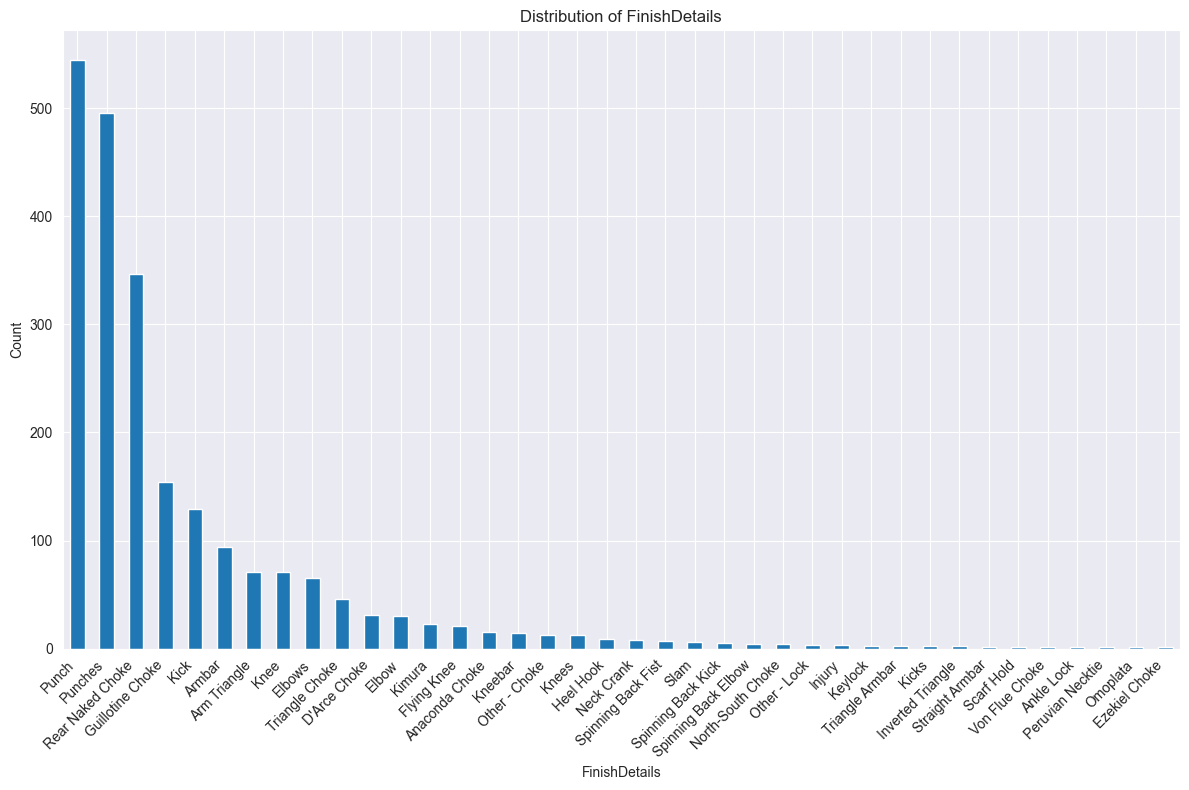

In [45]:
finish_details_counts = ufc_data_master['FinishDetails'].value_counts()

plt.figure(figsize=(12, 8))
finish_details_counts.plot(kind='bar')
plt.title('Distribution of FinishDetails')
plt.xlabel('FinishDetails')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Most common submission

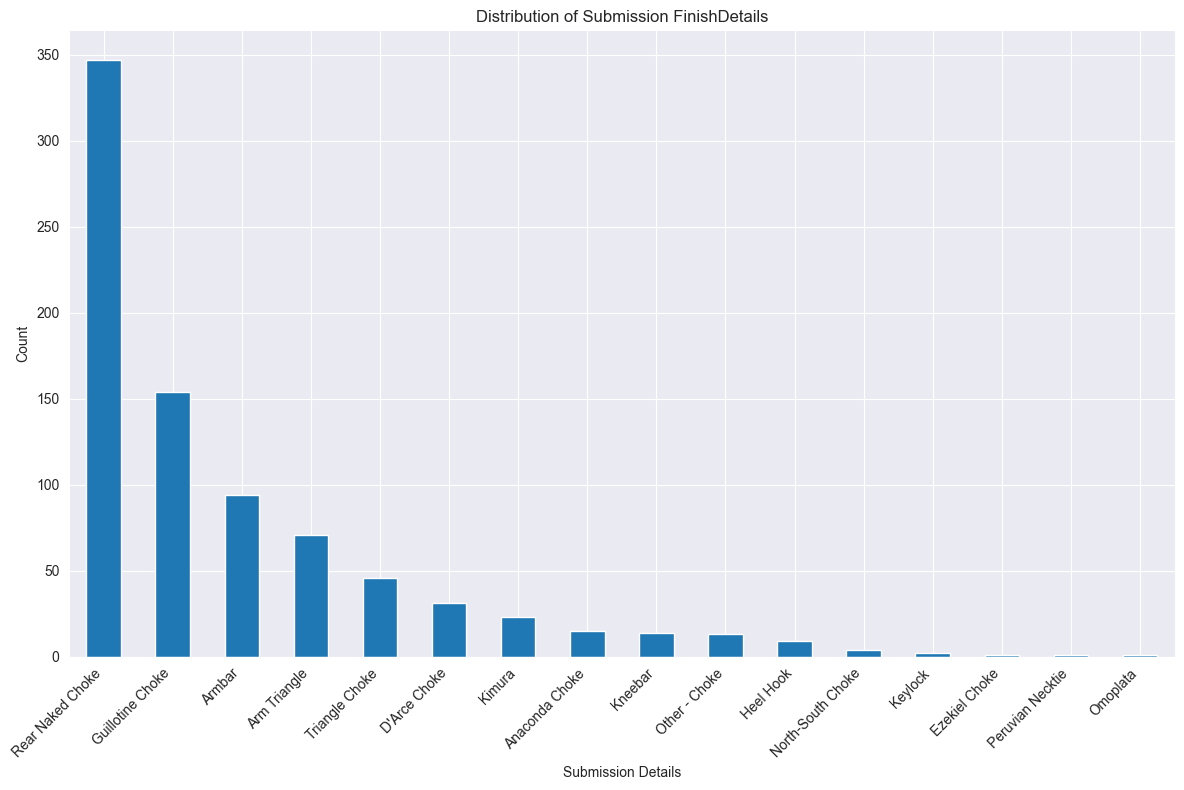

In [46]:
submission_keywords = [
    'Rear Naked Choke', 'Armbar', 'Guillotine Choke', 'Arm Triangle',
    "D'Arce Choke", 'Triangle Choke', 'Kimura', 'Ezekiel Choke',
    'Kneebar', 'Anaconda Choke', 'Heel Hook', 'Keylock',
    'Other - Choke', 'Peruvian Necktie', 'Omoplata', 'North-South Choke'
]

submission_details = ufc_data_master[ufc_data_master['FinishDetails'].isin(submission_keywords)]

submission_counts = submission_details['FinishDetails'].value_counts()

plt.figure(figsize=(12, 8))
submission_counts.plot(kind='bar')
plt.title('Distribution of Submission FinishDetails')
plt.xlabel('Submission Details')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

ufc_data_master.drop(['FinishDetails'], axis=1, inplace=True)

## Submission statistics matrix

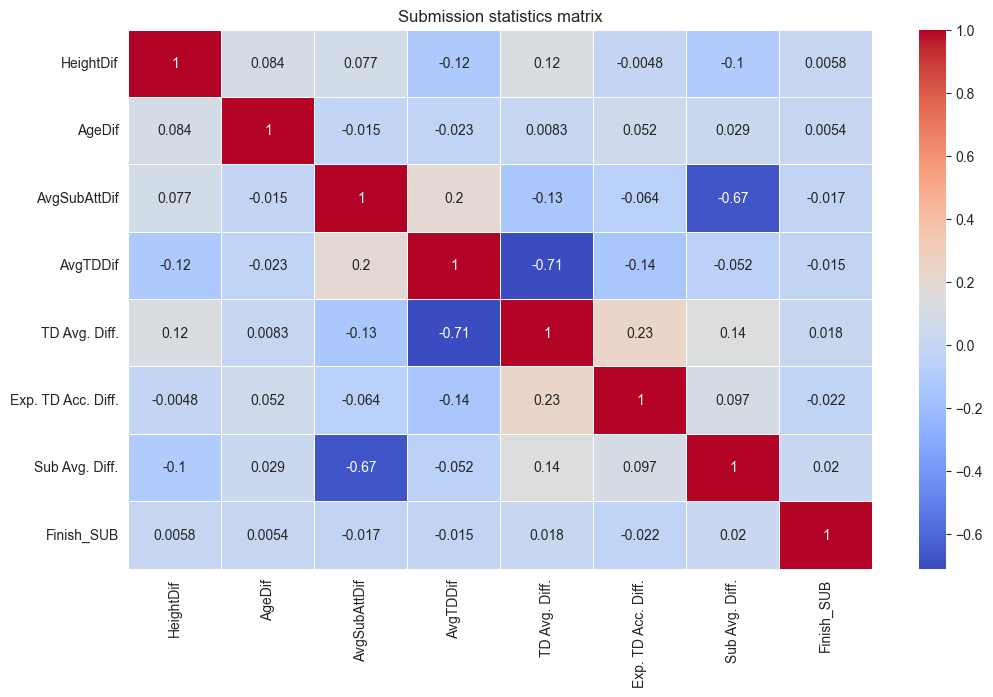

In [47]:
submission_features = ["HeightDif","AgeDif","AvgSubAttDif","AvgTDDif","TD Avg. Diff.","Exp. TD Acc. Diff.", "Sub Avg. Diff.", "Finish_SUB"]

correlation_submission = ufc_data_master[submission_features]

correlation_matrix_submission = correlation_submission.corr()

plt.figure(figsize=(12,7))
sns.heatmap(correlation_matrix_submission, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Submission statistics matrix')
plt.show()

## Decision statistics matrix

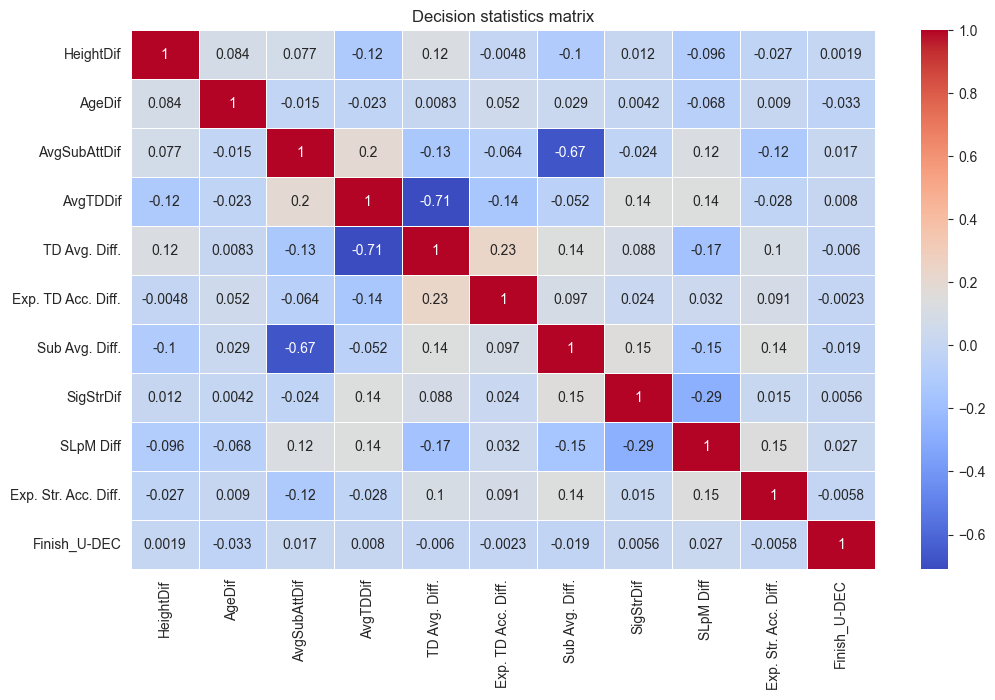

In [48]:
decision_features = ["HeightDif","AgeDif","AvgSubAttDif","AvgTDDif","TD Avg. Diff.","Exp. TD Acc. Diff.", "Sub Avg. Diff.","SigStrDif","SLpM Diff","Exp. Str. Acc. Diff.", "Finish_U-DEC"]

correlation_decision = ufc_data_master[decision_features]

correlation_matrix_decision = correlation_decision.corr()

plt.figure(figsize=(12,7))
sns.heatmap(correlation_matrix_decision, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Decision statistics matrix')
plt.show()

## Scatter plot for Finish_KO/TKO

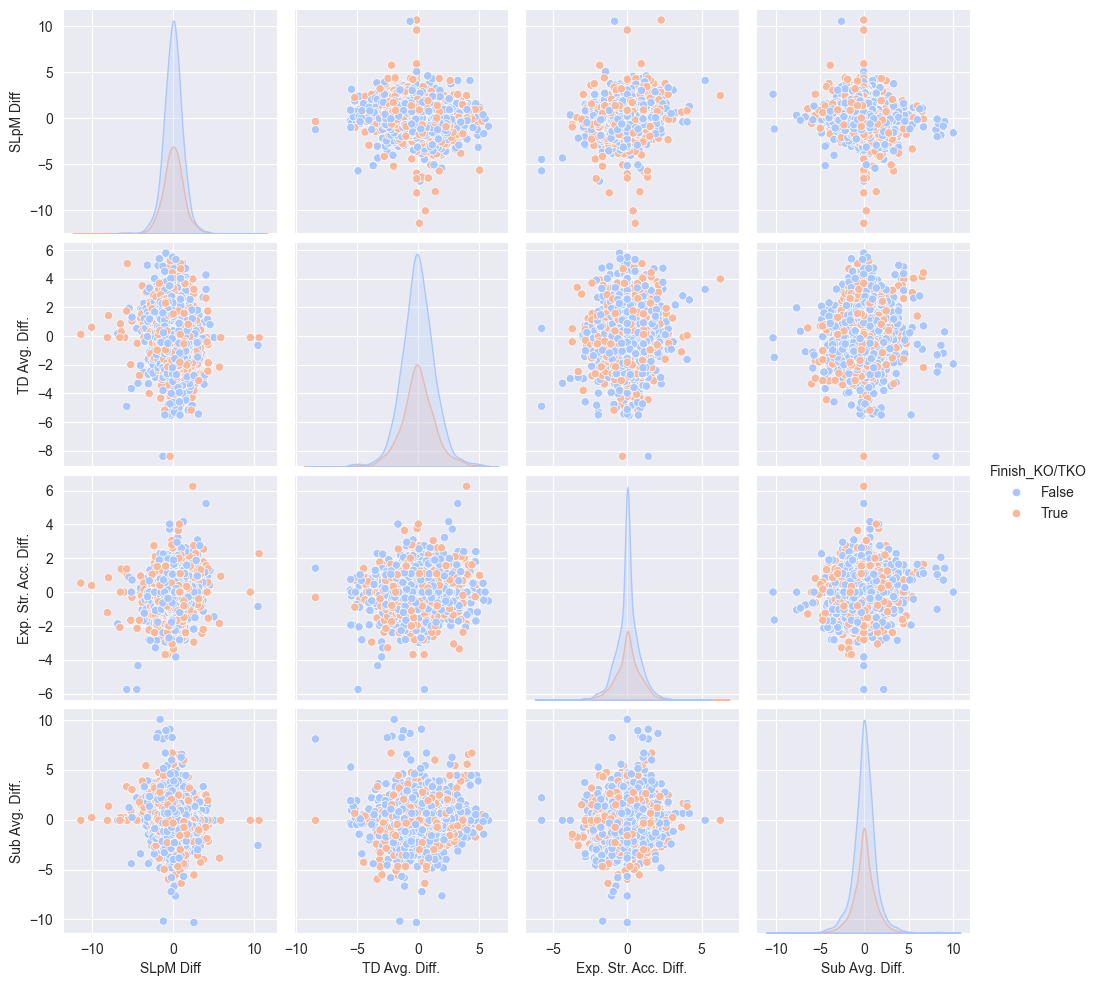

In [49]:
sns.pairplot(data=ufc_data_master, vars=["SLpM Diff",
       "TD Avg. Diff.", "Exp. Str. Acc. Diff.", "Sub Avg. Diff."],
             hue="Finish_KO/TKO", palette="coolwarm", diag_kind="kde")
plt.show()

# Modelling

## Logistic regression

In [50]:
X = ufc_data_master.drop(columns=['RedOdds', 'RedDecOdds','BlueOdds','RSubOdds','BSubOdds','RKOOdds','BKOOdds','BlueOdds','Finish_KO/TKO', 'Finish_SUB', 'Finish_U-DEC','Finish_Overturned','BlueDecOdds','Finish_M-DEC','Finish_DQ','Finish_S-DEC','Winner'])
# selected_features = [
#     'SLpM Diff', 'Exp. Str. Acc. Diff.', 'TD Avg. Diff.',
#     'Exp. TD Acc. Diff.', 'Sub Avg. Diff.', 'HeightDif', 'ReachDif',
#     'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'
# ]
# X = ufc_data_master[selected_features]

# y = ufc_data_master['Finish_KO/TKO']
# y = ufc_data_master['Finish_SUB']
# y = ufc_data_master['Finish_U-DEC']
y = ufc_data_master['Winner']

X = X.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight='balanced') #that way i oversample and i balance the set, however r2 drops
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)

r2 = r2_score(pd.get_dummies(y_test), y_pred_proba)
print(f"R-squared (R2): {r2:.2f}")

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression model accuracy (in %):", acc)

print("Classification Report:")
print(classification_report(y_test, y_pred))


R-squared (R2): 0.09
Logistic Regression model accuracy (in %): 0.6385542168674698
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.64      0.67       562
           1       0.58      0.63      0.60       434

    accuracy                           0.64       996
   macro avg       0.64      0.64      0.64       996
weighted avg       0.64      0.64      0.64       996



## Confusion matrix

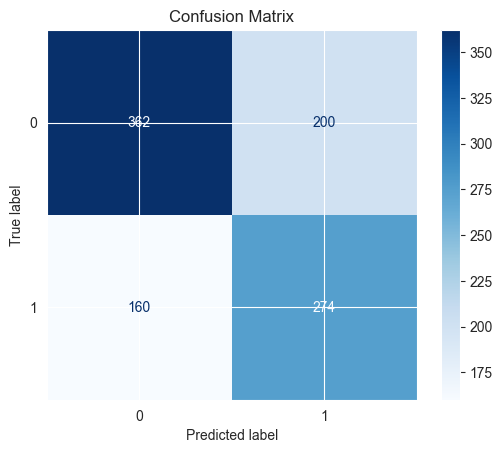

In [51]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Feature Importance

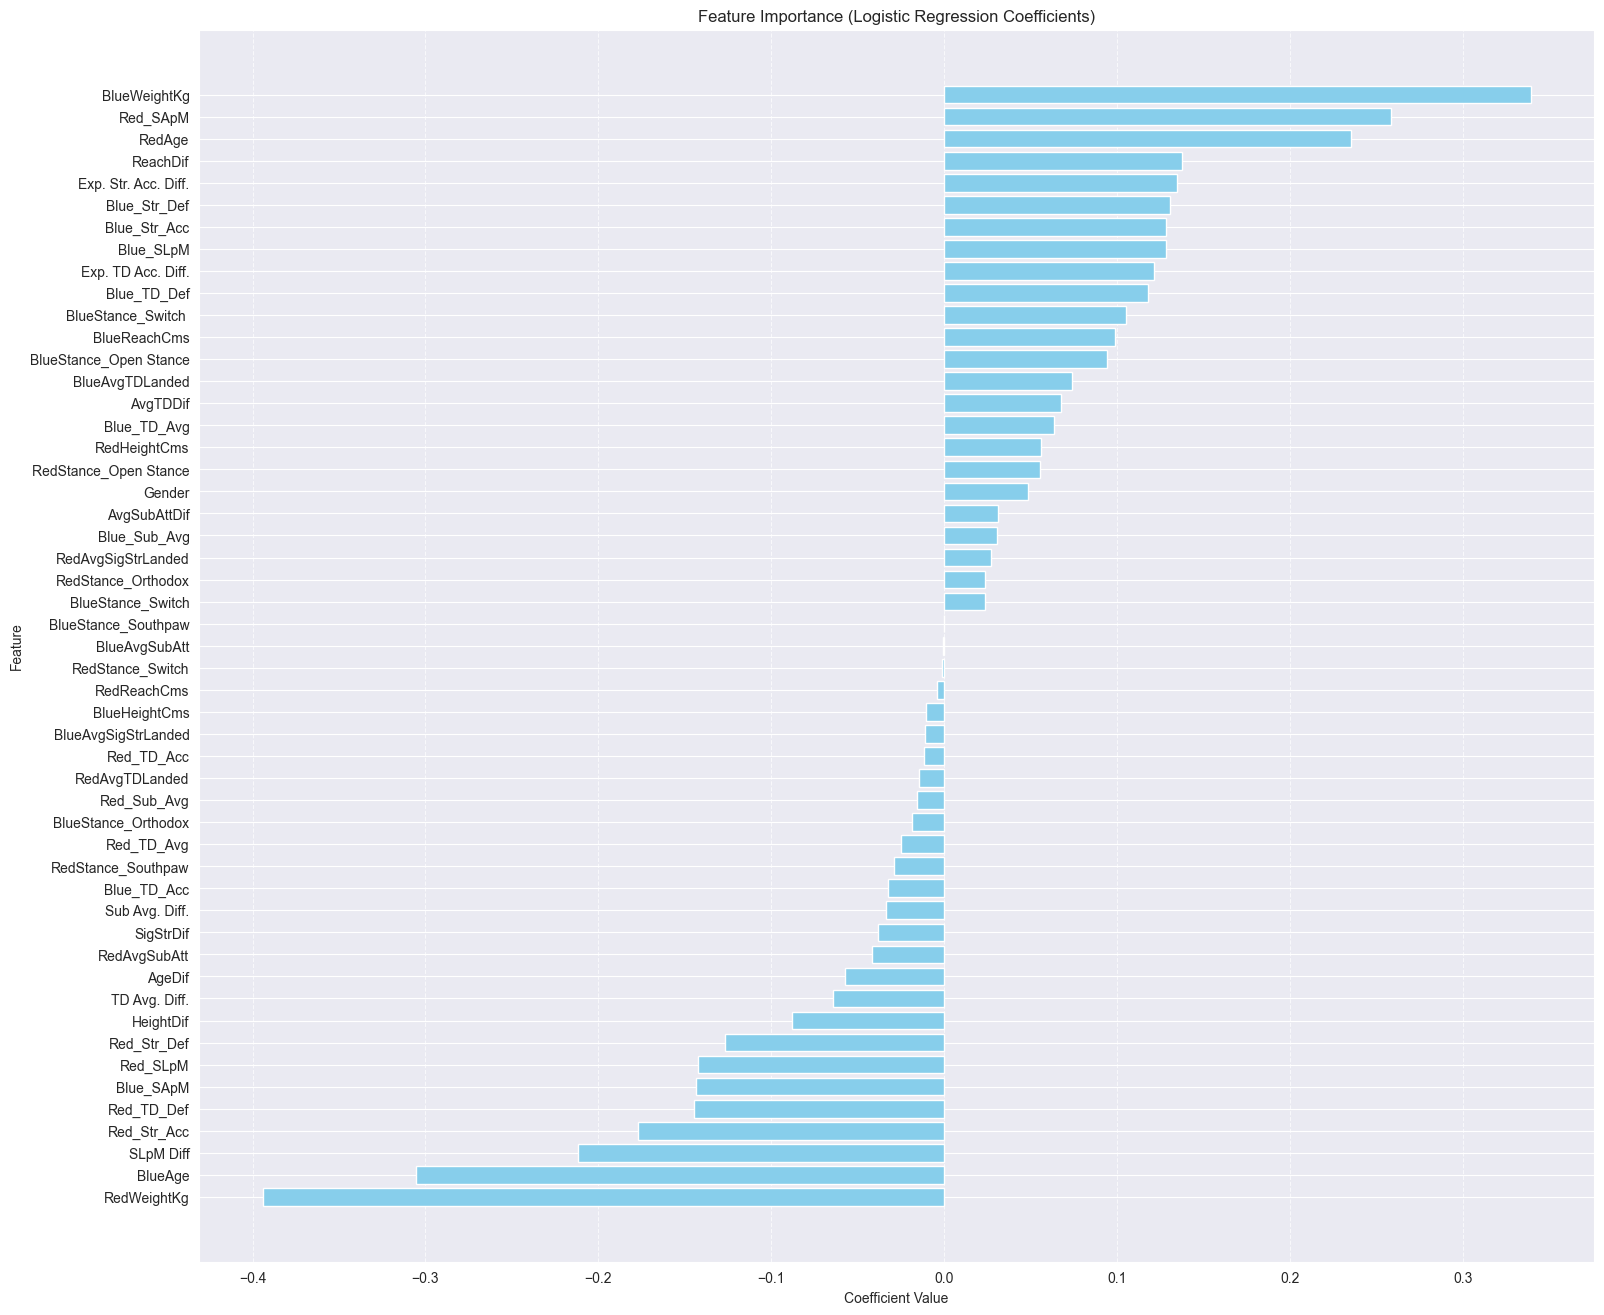

In [52]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0] 
}).sort_values(by='Coefficient', ascending=True)

plt.figure(figsize=(18, 16))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Balancing the set

#### Hyperparameter tuning

Best Parameters: {'C': 0.01, 'solver': 'lbfgs'}
R-squared (R²): 0.10
Logistic Regression model accuracy (in %): 63.75502008032129
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       562
           1       0.62      0.44      0.52       434

    accuracy                           0.64       996
   macro avg       0.63      0.62      0.61       996
weighted avg       0.63      0.64      0.63       996



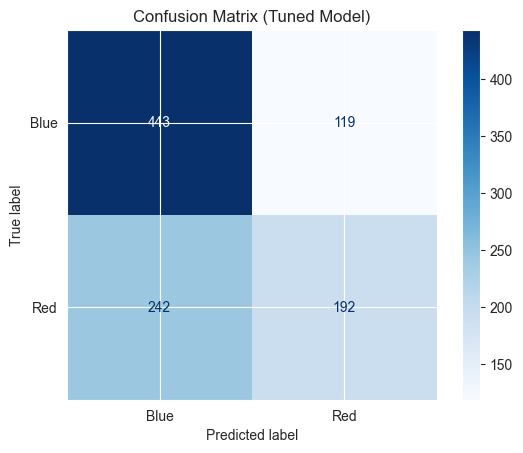

In [53]:
# Define the parameter grid for tuning
param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='r2')
grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)
y_pred_proba = best_model.predict_proba(x_test)

r2 = r2_score(pd.get_dummies(y_test), y_pred_proba)
print(f"R-squared (R²): {r2:.2f}")

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression model accuracy (in %):", acc * 100)

print("Classification Report:")
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay.from_estimator(best_model, x_test, y_test, display_labels=['Blue', 'Red'], cmap='Blues')
disp.ax_.set_title("Confusion Matrix (Tuned Model)")
plt.show()

#### Oversampling

Helps create synthetic samples for Red wins to balance the dataset. There is also a risk involved: duplicated samples or synthetic samples may cause the model to memorize patterns instead of learning generalizable features.

In [62]:
X = pd.DataFrame(X_scaled, columns=X.columns)
y = y

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test) 
y_pred = model.predict(X_test) 

#Ensuring the lengths of the y_test and y_pred_prob match before calculating r^2
if len(y_test) != len(y_pred_proba):
    print("Mismatch in lengths of y_test and y_pred_proba")
else:

    y_test_encoded = pd.get_dummies(y_test)

    r2 = r2_score(y_test_encoded, y_pred_proba)
    print(f"R-squared (R²): {r2:.2f}")

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression model accuracy (in %):", acc)
print("Classification Report (Oversampled Data):")
print(classification_report(y_test, y_pred))

R-squared (R²): 0.11
Logistic Regression model accuracy (in %): 0.639647577092511
Classification Report (Oversampled Data):
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       575
           1       0.63      0.67      0.65       560

    accuracy                           0.64      1135
   macro avg       0.64      0.64      0.64      1135
weighted avg       0.64      0.64      0.64      1135



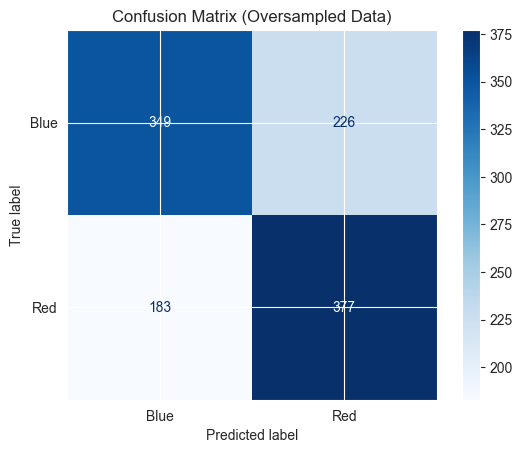

In [63]:
# Confusion matrix for oversampling
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Blue', 'Red'], cmap='Blues')
disp.ax_.set_title("Confusion Matrix (Oversampled Data)")
plt.show()

#### Undersampling
- Ensures the model doesn't "overlearn" patterns from the majority class (e.g., always predicting `Blue`).
- Forces the model to treat the minority class (`Red`) equally during training, improving its ability to predict `Red` wins.

In [64]:
# Combine features and target into a single DataFrame
data_combined = pd.concat([pd.DataFrame(X), y.reset_index(drop=True)], axis=1)
data_combined.columns = list(X.columns) + ['Winner']

# Separate the minority and majority classes
majority_class = data_combined[data_combined['Winner'] == 0]  # Blue
minority_class = data_combined[data_combined['Winner'] == 1]  # Red

# Undersample the majority class
majority_undersampled = resample(majority_class,
                                  replace=False,  # Sample without replacement
                                  n_samples=len(minority_class),  # Match minority class size
                                  random_state=42)

# Combine the undersampled majority class with the minority class
undersampled_data = pd.concat([majority_undersampled, minority_class])

X_undersampled = undersampled_data.drop(columns=['Winner'])
y_undersampled = undersampled_data['Winner']

X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

r2 = r2_score(y_test_encoded, y_pred_proba)
print(f"R-squared (R²): {r2:.2f}")

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression model accuracy (in %):", acc)
print("Classification Report:")
print(classification_report(y_test, y_pred))

R-squared (R²): 0.11
Logistic Regression model accuracy (in %): 0.6658878504672897
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.69       452
           1       0.65      0.64      0.64       404

    accuracy                           0.67       856
   macro avg       0.66      0.66      0.66       856
weighted avg       0.67      0.67      0.67       856



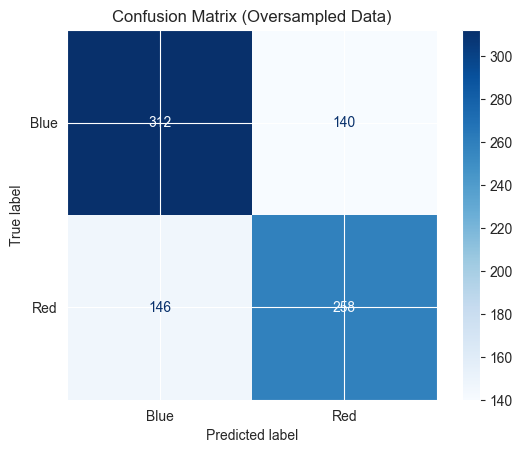

In [65]:
# Confusion matrix for oversampling
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Blue', 'Red'], cmap='Blues')
disp.ax_.set_title("Confusion Matrix (Oversampled Data)")
plt.show()

# Example fight prediction